Test brouillon Clo

The `solve_steady_state` method return a `SteadyStateDict` object. 

`ss`stores variables in 2 levels: top and internal:
- top level = scalars, which are accessible for all blocks of the model 
- the internal level = block-specific multidimnesion variables

## Main replication file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json

#from .result_dict import ResultDict

import sequence_jacobian as sj # sequence-space Jacobian toolkit

from household import hh_ha, hh_ta, hh_ra

In [2]:
print(dir(sj))

['ImpulseDict', 'JacobianDict', 'SteadyStateDict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'agrid', 'apply_function', 'blocks', 'classes', 'combine', 'create_model', 'drawdag', 'estimation', 'formatwarning_orig', 'grids', 'het', 'hetblocks', 'interpolate', 'interpolate_y', 'markov_rouwenhorst', 'markov_tauchen', 'misc', 'setmin', 'simple', 'solved', 'utilities', 'warnings']


In [3]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})
# plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

In [4]:
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y               # production technology (to first order, i.e. ignoring any Calvo or Rotemberg distortion)
    wN = Y / mu
    div = Y - wN
    return N, wN, div

In [5]:
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.simple
def nom_ST_bonds(r_ante, pi):
    """Bond returns if bonds are short term and nominal"""
    # real return adjusted downward by any excess of expected over actual inflation
    pi_e = pi(1)
    r_post_bonds = (1 + r_ante(-1)) * (1 + pi_e(-1))/(1 + pi) - 1
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.solved(unknowns={'qbond': (0.001, 100.)}, targets=['q_res'], solver="brentq")
def real_LT_bonds(qbond, r_ante, delta):
    """Bond returns if bonds are long term and real"""
    # equation for end-of-period price q of stream of future coupons (1,delta,delta^2,...): q_res=0
    q_res = qbond - (1 + delta * qbond(+1)) / (1 + r_ante)

    # ex-post return on bonds is coupon today plus delta times value of remaining coupon stream
    # divided by yesterday's end-of-period price
    r_post_bonds = (1 + delta * qbond) / qbond(-1) - 1
    return r_post_bonds, q_res

In [6]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

In [7]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

In [ ]:
# also add option to tax richest type at margin
    y = y.reshape(-1, n_e)  # reshape to beta*e grid
    y[:, -1] -= Tax_richest / pi_e[-1].sum()  # tax richest e type
    y = y.ravel()  # flatten back

@sj.simple
def top_t10_b20(c,D,centiles):

    Distrib_allstates = ss.internals['hh_ha']['D'].sum(axis=0)

    Cumul_sum = np.cumsum(Distrib_allstates)
    centiles = []
    for i in range(0,101):
        idx = np.abs(Cumul_sum - (i/100)).argmin()
        print(idx)
    centiles.append(ss.internals['hh_ha']['c'][idx])
    c_10_20 = centiles[90]/centiles[20]

    return c_10_20   

In [8]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

In [9]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

In [10]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

In [11]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

In [12]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

In [13]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

1.1142857142857143

In [14]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

In [15]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

In [16]:
ss = {}

In [17]:
with open('hh_params.json') as f:
    ha_params = json.load(f)

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']

(2.0236257114447653e-11, 5.881724645107056e-07, -2.220446049250313e-18)

In [18]:
print(ss)

{'ha': <SteadyStateDict: ['Y', 'mu', 'r_ante', 'B', 'G', 'tax_rate_shock', 'T_shock', 'T_rule_coeff', 'pi', 'kappa', 'beta_ave', 'vscale', 'frisch', 'eis', 'min_a', 'max_a', 'n_a', 'beta_hi', 'dbeta', 'omega', 'q', 'Tr_lumpsum', 'Tax_richest', 'zeta', 'r_post_bonds', 'qbond', 'N', 'wN', 'div', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'p', 'r_post_equity', 'cap_cond', 'r', 'A', 'C', 'asset_mkt', 'goods_mkt', 'nkpc_res'], internals=['hh_ha']>}


In [19]:
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

In [20]:
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

In [21]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A','c','D'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

In [21]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

In [22]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y'], targets=['asset_mkt'],
                                            inputs={'B': dB}, outputs=['Y'], Js=Js)['Y'] for k in model_names}

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/tk/zvlm5zxj4gzfjmrhd2466bv40000gn/T/ipykernel_3393/2220617584.py:6: SyntaxWarning: invalid escape sequence '\%'


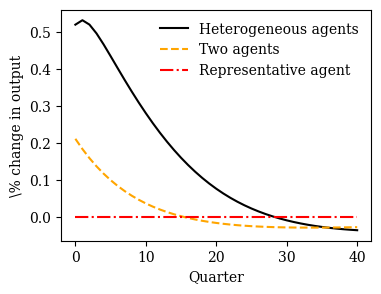

In [23]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

In [24]:
print(f'Micro outputs: {hh_ha.internals}')
# there is the consumption variable 'c' in the dictionnary

Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'e_grid', 'a_grid', 'beta', 'pi_pdf', 'y']


Micro outputs:
- `D`
- `Dbeg`
- `Pi`
- `Va`
- `a`
- `c`
- `e_grid`
- `a_grid`
- `beta`
- `pi_pdf`
- `y`

In [25]:
partial_eq = hh_ha.steady_state({**ha_params, **common_params})

In [26]:
partial_eq.internals['hh_ha']['c'].min() 
# minimum de consumption is 0.003722594


0.003722594280479629

In [27]:
global_eq =  hh_ha.steady_state({**ha_params, **common_params})
#global_eq.outputs['hh_ha']['c'].min() 

In [28]:
print(ss['ha']['C'])

0.8000005881724646


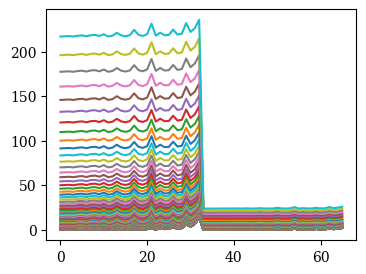

In [29]:
trunc = 275
plt.plot(partial_eq.internals['hh_ha']['c'][:trunc])

In [30]:
print(partial_eq.internals['hh_ha']['c']) # we have all beta-income states thus 66 rows 
print(partial_eq.internals['hh_ha']['c'].shape)
# shape(66,200)
c_ss = partial_eq.internals['hh_ha']['c']

[[3.72259428e-03 1.15343342e-02 1.74260891e-02 ... 1.77284595e+02
  1.95940290e+02 2.16844918e+02]
 [8.60009640e-03 1.92159874e-02 2.61499403e-02 ... 1.77501766e+02
  1.96157297e+02 2.17061757e+02]
 [1.77969770e-02 2.91833363e-02 3.94571307e-02 ... 1.77788184e+02
  1.96443558e+02 2.17347853e+02]
 ...
 [8.49723765e-01 8.49826507e-01 8.49931591e-01 ... 2.00151801e+01
  2.20534188e+01 2.43378132e+01]
 [1.28636041e+00 1.28645158e+00 1.28654482e+00 ... 2.04884479e+01
  2.25273795e+01 2.48124537e+01]
 [2.18601461e+00 2.18610084e+00 2.18618904e+00 ... 2.15476527e+01
  2.35898784e+01 2.58782987e+01]]
(66, 200)


In [31]:
print(partial_eq.internals['hh_ha']['Dbeg']) # we have all beta-income states thus 66 rows 
print(partial_eq.internals['hh_ha']['Dbeg'].shape)
# shape(66,200)
D_ss = partial_eq.internals['hh_ha']['Dbeg']

[[9.56951919e-05 5.11270815e-06 2.51387065e-06 ... 1.30398110e-15
  2.76500882e-16 4.62625885e-17]
 [2.83996384e-04 8.85267768e-06 5.05242332e-06 ... 3.15521539e-15
  6.67643258e-16 1.10477996e-16]
 [6.15950775e-04 1.34268782e-05 8.14296581e-06 ... 5.71876573e-15
  1.20756095e-15 1.97862989e-16]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.65460085e-12
  9.78486494e-13 2.56958980e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.45186932e-12
  1.35710202e-12 3.83201661e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.01863442e-12
  1.93625307e-12 5.84876683e-13]]
(66, 200)


In [32]:

#c_ss = partial_eq.internals['hh_ha']['c']
print(partial_eq.internals['hh_ha']['c'].sum(axis=0))
print(partial_eq.internals['hh_ha']['c'].sum(axis=0).shape)

[  60.29449502   60.63516624   60.95779717   61.27070123   61.57422571
   61.86864419   62.15437224   62.435442     62.70777145   62.98004991
   63.24888874   63.50939729   63.76855223   64.02765051   64.28560993
   64.54329452   64.7986562    65.05236365   65.30812867   65.56373154
   65.8196603    66.07654844   66.33454185   66.5943944    66.85564688
   67.11737847   67.37973645   67.64360638   67.90940714   68.17446237
   68.44119439   68.71029396   68.98146602   69.25500465   69.53053315
   69.80906939   70.09133533   70.37739725   70.66635632   70.9586085
   71.2547285    71.55261352   71.85274256   72.15668942   72.46278712
   72.77326224   73.08774092   73.40637983   73.72914291   74.05618645
   74.38819491   74.72575313   75.06911579   75.41807755   75.77303648
   76.13447902   76.50223269   76.87638095   77.25803736   77.64686221
   78.04267903   78.44648179   78.85842455   79.27854672   79.70717716
   80.14482639   80.59185039   81.04918551   81.51759966   81.99744967
   82.4

In [33]:
#print(partial_eq.internals['hh_ha']['e_grid'])
print(partial_eq.internals['hh_ha']['e_grid'].shape) # productivity grid 
# shape(66,)
# D = ss.internals['hh_ha']['D'].sum(axis=0) # distribution over asset grid alone

(66,)


In [34]:
y_ss =partial_eq.internals['hh_ha']['y']
print(partial_eq.internals['hh_ha']['y'])
print(partial_eq.internals['hh_ha']['y'].shape) # total income per person 
# shape(66,)
print(partial_eq.internals['hh_ha']['y'].sum(axis=0))
# total income at ss 228.33073118410147

[3.72259428e-03 8.60009640e-03 1.77969770e-02 2.47033364e-02
 3.24915031e-02 5.10041046e-02 5.70707036e-02 6.42911774e-02
 8.10396639e-02 1.18101699e-01 1.27213428e-01 1.63932665e-01
 2.15615363e-01 2.32250440e-01 3.38465982e-01 3.78724267e-01
 4.26639721e-01 4.80617345e-01 5.37783591e-01 7.83729200e-01
 8.44195187e-01 1.11034279e+00 1.43083521e+00 1.54122635e+00
 2.24607856e+00 2.83120420e+00 3.18940262e+00 3.56876085e+00
 5.60212468e+00 7.36829424e+00 1.02276612e+01 2.11650478e+01
 4.88963980e+01 3.72259428e-03 8.60009640e-03 1.77969770e-02
 2.47033364e-02 3.24915031e-02 5.10041046e-02 5.70707036e-02
 6.42911774e-02 8.10396639e-02 1.18101699e-01 1.27213428e-01
 1.63932665e-01 2.15615363e-01 2.32250440e-01 3.38465982e-01
 3.78724267e-01 4.26639721e-01 4.80617345e-01 5.37783591e-01
 7.83729200e-01 8.44195187e-01 1.11034279e+00 1.43083521e+00
 1.54122635e+00 2.24607856e+00 2.83120420e+00 3.18940262e+00
 3.56876085e+00 5.60212468e+00 7.36829424e+00 1.02276612e+01
 2.11650478e+01 4.889639

In [35]:
print(partial_eq.internals['hh_ha']['beta'])
print(partial_eq.internals['hh_ha']['beta'].shape) # beta grid 
# shape(66,)
# de 0 à 32 obs -> 0.91, de 33 a 67 -> 0.98

[0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287]
(66,)


In [36]:
pi_pdf_ss = partial_eq.internals['hh_ha']['pi_pdf']
print(partial_eq.internals['hh_ha']['pi_pdf'].shape) # stationary distribution over all joint (β,e)(β,e)-states.
# shape(66,)
# de 0 à 32 obs -> 0.91, de 33 a 67 -> 0.98
print(partial_eq.internals['hh_ha']['pi_pdf'].sum(axis=0))

(66,)
1.0000000000000981


In [37]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['pi_pdf']
print(partial_eq.internals['hh_ha']['Dbeg'])
print(partial_eq.internals['hh_ha']['Dbeg'].shape)
#shape (66,200)

[[9.56951919e-05 5.11270815e-06 2.51387065e-06 ... 1.30398110e-15
  2.76500882e-16 4.62625885e-17]
 [2.83996384e-04 8.85267768e-06 5.05242332e-06 ... 3.15521539e-15
  6.67643258e-16 1.10477996e-16]
 [6.15950775e-04 1.34268782e-05 8.14296581e-06 ... 5.71876573e-15
  1.20756095e-15 1.97862989e-16]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.65460085e-12
  9.78486494e-13 2.56958980e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.45186932e-12
  1.35710202e-12 3.83201661e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.01863442e-12
  1.93625307e-12 5.84876683e-13]]
(66, 200)


In [38]:
D_ss = partial_eq.internals['hh_ha']['D']
test = D_ss*c_ss
print(np.sum(test))


0.8000005881724652


In [39]:
np.sum(c_ss)
#np.sum(D_ss)

114001.81722578834

In [40]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['Pi']
print(partial_eq.internals['hh_ha']['Pi'])
print(partial_eq.internals['hh_ha']['Pi'].shape) # transition matrix 
#shape (66,66)

[[4.28054646e-01 1.39564528e-02 5.25960451e-04 ... 6.05531230e-08
  4.26968584e-08 2.77430211e-08]
 [1.59147057e-04 4.30704726e-01 1.15611827e-02 ... 6.05531229e-08
  4.26968584e-08 2.77430211e-08]
 [1.59147058e-04 2.44929323e-04 4.33370781e-01 ... 6.05531230e-08
  4.26968585e-08 2.77430212e-08]
 ...
 [2.88355405e-08 4.43782595e-08 6.29377033e-08 ... 4.33286686e-01
  2.44881795e-04 1.59116175e-04]
 [2.88355405e-08 4.43782595e-08 6.29377032e-08 ... 1.15589393e-02
  4.30621148e-01 1.59116175e-04]
 [2.88355405e-08 4.43782595e-08 6.29377032e-08 ... 5.25858388e-04
  1.39537445e-02 4.27971582e-01]]
(66, 66)


In [41]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['Va']
print(partial_eq.internals['hh_ha']['Va'])
print(partial_eq.internals['hh_ha']['Va'].shape) # transition matrix 
#shape (66,200)

[[2.69973015e+02 8.71311670e+01 5.76721487e+01 ... 5.66885126e-03
  5.12911358e-03 4.63464863e-03]
 [1.16859155e+02 5.23002009e+01 3.84322101e+01 ... 5.66191550e-03
  5.12343927e-03 4.63001872e-03]
 [5.64702645e+01 3.44374607e+01 2.54706813e+01 ... 5.65279411e-03
  5.11597331e-03 4.62392421e-03]
 ...
 [1.18273731e+00 1.18259432e+00 1.18244811e+00 ... 5.02118890e-02
  4.55711657e-02 4.12937675e-02]
 [7.81274044e-01 7.81218678e-01 7.81162059e-01 ... 4.90520320e-02
  4.46123794e-02 4.05038540e-02]
 [4.59740751e-01 4.59722617e-01 4.59704070e-01 ... 4.66408111e-02
  4.26030174e-02 3.88356287e-02]]
(66, 200)


In [42]:
a_ss = partial_eq.internals['hh_ha']['a']
print(partial_eq.internals['hh_ha']['a'])
print(partial_eq.internals['hh_ha']['a'].shape) # assets 
#shape (66,200)
print(partial_eq.internals['hh_ha']['a'].sum(axis=0))

[[0.00000000e+00 3.57461940e-03 9.32870066e-03 ... 3.09436094e+03
  3.42854576e+03 3.80315880e+03]
 [0.00000000e+00 7.70468354e-04 5.48235155e-03 ... 3.09414865e+03
  3.42833363e+03 3.80294684e+03]
 [0.00000000e+00 0.00000000e+00 1.37204180e-03 ... 3.09387143e+03
  3.42805657e+03 3.80266994e+03]
 ...
 [9.37793745e+00 9.38922107e+00 9.40076182e+00 ... 3.26185429e+03
  3.61265657e+03 4.00588985e+03]
 [1.98786874e+01 1.98899826e+01 1.99015352e+01 ... 3.27231841e+03
  3.62312000e+03 4.01635259e+03]
 [4.67103834e+01 4.67216835e+01 4.67332412e+01 ... 3.29899056e+03
  3.64978885e+03 4.04301810e+03]]
(66, 200)
[1.68036236e+02 1.68447065e+02 1.68893059e+02 1.69366396e+02
 1.69867237e+02 1.70395832e+02 1.70952310e+02 1.71533201e+02
 1.72143170e+02 1.72774131e+02 1.73430097e+02 1.74116605e+02
 1.74827349e+02 1.75561728e+02 1.76321543e+02 1.77106678e+02
 1.77919953e+02 1.78761503e+02 1.79628450e+02 1.80523876e+02
 1.81448190e+02 1.82401689e+02 1.83385193e+02 1.84398951e+02
 1.85444465e+02 1.865237

In [43]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['Pi']
print(partial_eq.internals['hh_ha']['a_grid'])
print(partial_eq.internals['hh_ha']['a_grid'].shape) # asset grid
#shape (200,0)
print(partial_eq.internals['hh_ha']['a_grid'].sum(axis=0))

[0.00000000e+00 1.13297108e-02 2.29176074e-02 3.47710865e-02
 4.68978000e-02 5.93056658e-02 7.20028783e-02 8.49979195e-02
 9.82995709e-02 1.11916926e-01 1.25859401e-01 1.40136754e-01
 1.54759090e-01 1.69736884e-01 1.85080993e-01 2.00802670e-01
 2.16913585e-01 2.33425840e-01 2.50351988e-01 2.67705054e-01
 2.85498554e-01 3.03746514e-01 3.22463497e-01 3.41664626e-01
 3.61365605e-01 3.81582747e-01 4.02333003e-01 4.23633987e-01
 4.45504011e-01 4.67962111e-01 4.91028084e-01 5.14722522e-01
 5.39066847e-01 5.64083354e-01 5.89795247e-01 6.16226682e-01
 6.43402817e-01 6.71349853e-01 7.00095089e-01 7.29666972e-01
 7.60095152e-01 7.91410541e-01 8.23645379e-01 8.56833290e-01
 8.91009359e-01 9.26210199e-01 9.62474032e-01 9.99840765e-01
 1.03835208e+00 1.07805151e+00 1.11898457e+00 1.16119881e+00
 1.20474395e+00 1.24967200e+00 1.29603734e+00 1.34389691e+00
 1.39331026e+00 1.44433978e+00 1.49705078e+00 1.55151168e+00
 1.60779419e+00 1.66597344e+00 1.72612823e+00 1.78834120e+00
 1.85269902e+00 1.919292

In [44]:
somme_lignes = np.sum(D_ss[32, :]) + np.sum(D_ss[65, :])
print(somme_lignes)

0.00026325520422375607


In [45]:
somme_lignes_blo = np.sum(D_ss[24:33, :])  # Somme des lignes 32 et 33 (exclu)
somme_lignes_bhi = np.sum(D_ss[57:66, :])  # Somme des lignes 66 et 67 (exclu)
D_test_1 = (D_ss[24:33, :]) # 9 lines 
D_test_2 = (D_ss[57:66, :]) # 9 lines
# Somme totale
somme_totale = somme_lignes_blo + somme_lignes_bhi

# Affichage des résultats
print("Somme des lignes blo :", somme_lignes_blo)
print("Somme des lignes bhi :", somme_lignes_bhi)
print("Somme totale des lignes :", somme_totale)

Somme des lignes blo : 0.028804935306714432
Somme des lignes bhi : 0.02771357550484989
Somme totale des lignes : 0.056518510811564324


In [46]:
import numpy as np

def trouver_blocs(D_ss, seuil=0.1):
    """
    Trouve les indices x pour lesquels la somme des blocs (33-x) et (65-x) est inférieure au seuil,
    mais où l'extension des blocs dépasse le seuil.

    Parameters:
        D_ss (ndarray): Matrice de données (66 x 200).
        seuil (float): Seuil (par exemple, 10 pour 10%).

    Returns:
        tuple: (x_blo, x_bhi, somme_totale)
    """
    n_lignes, n_colonnes = D_ss.shape  # Dimensions de la matrice

    # Initialisation des indices de départ pour les blocs (33 et 65)
    n_blo, n_bhi = 33, 65

    # Test progressif avec le même x pour blo et bhi
    for x in range(1, n_blo):  # On teste x à partir de 1 jusqu'à 32
        # Somme des blocs combinés (33-x) et (65-x)
        test_1 = n_blo - x
        test_2 = n_bhi - x
        somme_lignes_blo = np.sum(D_ss[test_1:n_blo, :])  # Somme des lignes dans blo (33-x)
        somme_lignes_bhi = np.sum(D_ss[test_2:n_bhi, :])  # Somme des lignes dans bhi (65-x)
        
        # Somme totale des deux blocs combinés
        somme_totale = somme_lignes_blo + somme_lignes_bhi

        # Vérification si la somme totale est inférieure au seuil
        if somme_totale < seuil:
            # Si la somme totale est inférieure au seuil, vérifier l'extension des blocs
            somme_voisine = (
                np.sum(D_ss[n_blo - x - 1:n_blo, :]) +  # Étendre blo à (33-x-1)
                np.sum(D_ss[n_bhi - x - 1:n_bhi, :])    # Étendre bhi à (65-x-1)
            )
            # Si l'extension dépasse le seuil
            if somme_voisine > seuil:
                return n_blo - x, n_bhi - x, somme_totale

    # Retourne None si aucune condition n'est remplie
    return None, None, None

# Exemple d'utilisation
#D_ss = np.random.rand(66, 200) * 0.05  # Exemple de matrice avec des valeurs aléatoires
x_blo, x_bhi, somme_totale = trouver_blocs(D_ss, seuil=10)

# Affichage des résultats
print("Bloc blo trouvé (33-x) :", x_blo)
print("Bloc bhi trouvé (65-x) :", x_bhi)
print("Somme totale :", somme_totale)


Bloc blo trouvé (33-x) : None
Bloc bhi trouvé (65-x) : None
Somme totale : None


In [47]:
import numpy as np

def trouver_blocs_extension(D_ss, seuil=0.1):
    """
    Trouve les indices x pour lesquels la somme des blocs (33-x) et (65-x) est inférieure au seuil,
    puis affine le résultat en ajoutant progressivement les cellules les plus à droite pour atteindre la somme
    la plus proche possible de 10%, sans la dépasser.

    Parameters:
        D_ss (ndarray): Matrice de données (66 x 200).
        seuil (float): Seuil (par exemple, 0.1 pour 10%).

    Returns:
        tuple: (x_blo, x_bhi, somme_totale_approchee, colonnes_ajoutees)
    """
    n_lignes, n_colonnes = D_ss.shape  # Dimensions de la matrice

    # Initialisation des indices de départ pour les blocs (33 et 65)
    n_blo, n_bhi = 33, 66
    best_x_blo, best_x_bhi = None, None
    best_somme_totale = None

    # Test progressif avec le même x pour blo et bhi
    for x in range(1, n_blo):  # On teste x à partir de 1 jusqu'à 32
        # Somme des blocs combinés (33-x) et (65-x)
        test_1 = n_blo - x
        test_2 = n_bhi - x
        somme_lignes_blo = np.sum(D_ss[test_1:n_blo, :])  # Somme des lignes dans blo (33-x)
        somme_lignes_bhi = np.sum(D_ss[test_2:n_bhi, :])  # Somme des lignes dans bhi (65-x)
        
        # Somme totale des deux blocs combinés
        somme_totale = somme_lignes_blo + somme_lignes_bhi
        #print(somme_totale)

        # Vérification si la somme totale est inférieure au seuil
        if somme_totale < seuil:
            test_voisin_1 = n_blo - x - 1
            test_voisin_2 = n_bhi - x - 1
            # Si la somme totale est inférieure au seuil, vérifier l'extension des blocs
            somme_voisine = (    
                np.sum(D_ss[test_voisin_1 :n_blo, :]) +  # Étendre blo à (33-x-1)
                np.sum(D_ss[test_voisin_2:n_bhi, :])    # Étendre bhi à (65-x-1)
            )
            #print("all good")
            # Si l'extension dépasse le seuil
            if somme_voisine > seuil:
                # Sauvegarder la dernière combinaison valide
                best_x_blo, best_x_bhi = test_1, test_2
                best_somme_totale = somme_totale
                print("all good")

    # Affinage du résultat en ajoutant progressivement les cellules à droite (de droite à gauche)
    if best_x_blo is not None and best_x_bhi is not None:
        somme_cumulee = best_somme_totale
        colonnes_ajoutees = []
        
        for col in range(n_colonnes - 1, -1, -1):  # Parcours des colonnes de droite à gauche
            # Ajouter les valeurs des cellules des lignes sélectionnées et de leurs lignes précédentes
            somme_cumulee += np.sum(D_ss[best_x_blo:n_blo, col]) + np.sum(D_ss[best_x_bhi:n_bhi, col]) + np.sum(D_ss[best_x_blo - 1:n_blo - 1, col]) + np.sum(D_ss[best_x_bhi - 1:n_bhi - 1, col])

            colonnes_ajoutees.append(col)

            # Vérification que la somme ne dépasse pas le seuil de 10%
            if somme_cumulee > seuil:
                # Retourner la somme juste avant de dépasser le seuil
                somme_avant_depassement = somme_cumulee - (np.sum(D_ss[best_x_blo:n_blo, colonnes_ajoutees[-1]]) + np.sum(D_ss[best_x_bhi:n_bhi, colonnes_ajoutees[-1]]) + np.sum(D_ss[best_x_blo - 1:n_blo - 1, colonnes_ajoutees[-1]]) + np.sum(D_ss[best_x_bhi - 1:n_bhi - 1, colonnes_ajoutees[-1]]))
                return best_x_blo, best_x_bhi, somme_avant_depassement, colonnes_ajoutees

    # Retourne None si aucune condition n'est remplie
    return None, None, None, None

# Exemple d'utilisation
#D_ss = np.random.rand(66, 200) * 0.05  # Exemple de matrice avec des valeurs aléatoires
x_blo, x_bhi, somme_totale_approchee, colonne_ajoutee = trouver_blocs_extension(D_ss, seuil=0.1)

# Affichage des résultats
print("Bloc blo trouvé (33-x) :", x_blo)
print("Bloc bhi trouvé (65-x) :", x_bhi)
print("Somme totale juste avant de dépasser le seuil :", somme_totale_approchee)
print("Dernière colonne ajoutée avant de dépasser le seuil :", colonne_ajoutee)


all good
Bloc blo trouvé (33-x) : 24
Bloc bhi trouvé (65-x) : 57
Somme totale juste avant de dépasser le seuil : 0.09919033381491701
Dernière colonne ajoutée avant de dépasser le seuil : [199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144]


## Code Sofia 

In [48]:
T = 400

In [49]:
def count_var_percentage (desired_percentage, hh_distribution, var_distribution, top = True):
    if hh_distribution.shape != var_distribution.shape:
        raise Exception("Both distributions do not have the same size.")
    
    if top == False :
        percentage = 1-desired_percentage
    else:
        percentage = desired_percentage

    last_row = hh_distribution.shape[0]
    last_column = hh_distribution.shape[1]
    #print(last_row)
    #print(last_column)

    pre_sum = 0
    element_percentage = 0
    rest = 0
    last_element = np.array([last_row-1, last_column-1])
    condition_met = False
    var_aggregated = 0
    # Loop through matrix from bottom-right, left to right, then upwards
    # fomula [start]

    for r in range(last_row, -1, -1):  # Iterate over rows from bottom to top
        # r = 66
        for c in range(last_column, -1, -1):  # Iterate over columns from right to left
            # c=199
            element_percentage = pre_sum + hh_distribution[r-1,c-1]
            if element_percentage == percentage:
                var_aggregated += hh_distribution[r-1,c] * var_distribution[r-1,c-1]
                last_element = np.array([r-1, c-1])
                pre_sum = element_percentage
                condition_met = True
                break

            elif element_percentage > percentage:
                rest = percentage - pre_sum
                var_aggregated += rest * var_distribution[r-1,c-1]
                last_element = np.array([r-1, c-1])
                condition_met = True
                break

            elif element_percentage < percentage:
                pre_sum = element_percentage
                var_aggregated += hh_distribution[r-1,c-1] * var_distribution[r-1,c-1]
                
                last_element = np.array([r-1, c-1])
        if condition_met: break
    return last_element, var_aggregated, rest

In [50]:
hh_distribution = ss['ha'].internals['hh_ha']['D']
consumption_distribution = ss['ha'].internals['hh_ha']['c']

# getting the 10 richest (only beta high)
last_element_T10_bH, c_aggregated_T10_bH, rest = count_var_percentage (0.1, hh_distribution, consumption_distribution, top = T)
print(last_element_T10_bH)
print(c_aggregated_T10_bH)
print(ss['ha']['C'])

print(rest)

[ 51 166]
0.13408686676726841
0.8000005881724646
4.903383977744591e-05


In [51]:
# getting the 10 richest (both betas, decomposing by 5%)
last_element_T5_bL, c_aggregated_T5_bL, rest_bL = count_var_percentage (0.05, hh_distribution[:33,:], consumption_distribution[:33,:], top = T)
last_element_T5_bH, c_aggregated_T5_bH, rest_bH = count_var_percentage (0.05, hh_distribution[33:,:], consumption_distribution[33:,:], top = T)
c_aggregated_T10 = c_aggregated_T5_bH + c_aggregated_T5_bL
print(last_element_T5_bL) # OK 
print(34+last_element_T5_bH) # OK
print(c_aggregated_T10) #0.2469
print(ss['ha']['C']) # 0.80 # soit 30% de la consommation totale

print(rest_bL) # 00000
print(rest_bH) # 4,64e-05

[23 10]
[ 57 149]
0.24693368678535943
0.8000005881724646
0.000595539832186083
4.636642045408035e-05


In [ ]:
#Js_myopic = {'hh_ha': sj.JacobianDict(jac_, inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], name='hh')}

In [74]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y', 'c','D'], 
                                            Js=Js)for k in model_names}

In [64]:
irf = irfs_B['ha'] 

In [77]:
# Initialize the modified dictionary for storing updated IRFs
irfs_B_modified = {}

# Iterate through model types (ha, ra, ta) in the original IRF dictionary
for model_type, irf in irfs_B.items():
    # Ensure irf is of type sj.ImpulseDict
    if not isinstance(irf, sj.ImpulseDict):
        raise TypeError(f"Expected sj.ImpulseDict, but got {type(irf).__name__}")
    
    # Extract the 'c' and 'D' internals
    c_matrix = irf.internals.get('c', None)
    D_variable = irf.internals.get('D', None)
    print(c_matrix)
    
    # Validate the presence of 'c' and 'D'
    if c_matrix is None:
        raise KeyError(f"'c' (consumption matrix) not found in internals of model {model_type}.")
    if D_variable is None:
        raise KeyError(f"'D' variable not found in internals of model {model_type}.")
    
    # Validate the shape of 'c' (should be 66x200 as per your description)
    if c_matrix.shape != (66, 200):
        raise ValueError(f"Unexpected shape for 'c': {c_matrix.shape}. Expected (66, 200).")
    
    # Apply `function_sofia` to compute a single value per period
    # Assuming `function_sofia` is a function you have defined elsewhere
    # and it takes both `c` and `D` as inputs
    sofia_result = np.array([function_sofia(c_matrix[:, t], D_variable[t]) for t in range(c_matrix.shape[1])])
    
    # Add the new variable to the ImpulseDict
    modified_irf = sj.ImpulseDict(irf.toplevel.copy(), irf.internals.copy(), T=irf.T)
    modified_irf.toplevel['sofia_result'] = sofia_result
    
    # Add the modified IRF to the new dictionary
    irfs_B_modified[model_type] = modified_irf

# Now, irfs_B_modified contains the updated IRFs with the new variable `sofia_result`.


None


KeyError: "'c' (consumption matrix) not found in internals of model ha."

In [73]:


# Initialize the new dictionary to store modified IRFs
irfs_B_modified = {}

# Iterate through model types (ha, ra, ta) in the original IRF dictionary
for model_type, irf in irfs_B.items():
    # Access the impulse response for Y
    irf_Y = irf['Y']
    
    # Ensure irf is of type ImpulseDict
    if not isinstance(irf, sj.ImpulseDict):
        raise TypeError(f"Expected sj.ImpulseDict, but got {type(irf).__name__}")
    
    # Extract an internal variable (e.g., "internal_variable") using the `internals` attribute
    internal_var = irf.internals.get('internal_variable', np.zeros_like(irf_Y))
    
    # Create a new variable combining the original IRF and the internal variable
    # For example, we add them, but you can define any transformation
    new_variable = irf_Y + 0.5 * internal_var
    
    # Add the new variable to the ImpulseDict
    # Using the `sj.ImpulseDict` methods to ensure consistency
    modified_irf = sj.ImpulseDict(irf.toplevel.copy(), irf.internals.copy(), T=irf.T)
    modified_irf.toplevel['new_variable'] = new_variable
    
    # Add the modified IRF to the new dictionary
    irfs_B_modified[model_type] = modified_irf

# Now, irfs_B_modified contains the updated IRFs with the new variable included.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [65]:
block1 = irf.internals.get("block1", {})

AttributeError: 'numpy.ndarray' object has no attribute 'internals'

In [53]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['c'], 
                                            Js=Js)['c'] for k in model_names}

KeyError: 'c'

In [123]:
irfs_B_y = {k: models[k].solve_impulse_linear(ss[k], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y'], 
                                            Js=Js)['Y'] for k in model_names}

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/tk/zvlm5zxj4gzfjmrhd2466bv40000gn/T/ipykernel_4691/884564705.py:6: SyntaxWarning: invalid escape sequence '\%'


Text(0, 0.5, '\\% change in output')

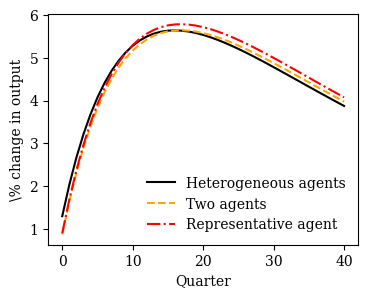

In [ ]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in asset')
#plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

In [ ]:
def top_consumption(c, D):
    if D.shape != c.shape:
        raise Exception("Both distributions do not have the same size.")
    
    fct_output = []
    for percentage in [0.05, 0.25]:
            
            beta_sums = []
            for beta_state in [1, 2]:
                if beta_state == 1: # s'assurer de bhi et blo
                    D_beta = D[:33,:]
                    c_beta = c[:33,:]
                else:
                    D_beta = D[33:,:]
                    c_beta = c[33:,:]

                last_row = D_beta.shape[0]
                last_column = D_beta.shape[1]
                pre_sum = 0
                element_percentage = 0
                rest = 0
                last_element = np.array([last_row-1, last_column-1])
                condition_met = False
                var_aggregated = 0

                for row in range(last_row, -1, -1):  # Iterate over rows from bottom to top
                    for col in range(last_column, -1, -1):  # Iterate over columns from right to left
                        element_percentage = pre_sum + D_beta[row-1,col-1]

                        if element_percentage == percentage: 
                            # if at this cell we meet the exact mass percentage we are looking for
                            var_aggregated += D_beta[row-1,col-1] * c_beta[row-1,col-1]
                            last_element = np.array([row-1,col-1])
                            pre_sum = element_percentage
                            condition_met = True
                            beta_sums.append(var_aggregated)
                            break

                        elif element_percentage > percentage:
                            # if at this cell we meet more than the exact mass percentage we are looking for
                            rest = percentage - pre_sum
                            var_aggregated += rest * c_beta[row-1,col-1]
                            last_element = np.array([row-1,col-1])
                            condition_met = True
                            beta_sums.append(var_aggregated)
                            break

                        elif element_percentage < percentage:
                            # if at this cell we meet less than the mass percentage we are looking for
                            # sum and continue
                            pre_sum = element_percentage
                            var_aggregated += D_beta[row-1,col-1] * c_beta[row-1,col-1]
                            last_element = np.array([row-1,col-1])

                    if condition_met: break
            beta_sum_total = sum(beta_sums)
            fct_output.append(beta_sum_total)

    print(fct_output)
    c_t10 = fct_output[0]
    c_t50 = fct_output[1]

    return c_t10, c_t50

In [39]:
def top_consumption(c, D):
    if D.shape != c.shape:
        raise Exception("Both distributions do not have the same size.")
    
    for percentage in [0.05, 0.25]:
            
            last_case = []
            for beta_state in [1, 2]:
                if beta_state == 1: # s'assurer de bhi et blo
                    D_beta = D[:33,:]
                    c_beta = c[:33,:]
                else:
                    D_beta = D[33:,:]
                    c_beta = c[33:,:]

                last_row = D_beta.shape[0]
                last_column = D_beta.shape[1]
                pre_sum = 0
                element_percentage = 0
                rest = 0
                last_element = np.array([last_row-1, last_column-1])
                condition_met = False
                var_aggregated = 0

                for row in range(last_row, -1, -1):  # Iterate over rows from bottom to top
                    for col in range(last_column, -1, -1):  # Iterate over columns from right to left
                        element_percentage = pre_sum + D_beta[row-1,col-1]

                        if element_percentage == percentage: 
                            # if at this cell we meet the exact mass percentage we are looking for
                            var_aggregated += D_beta[row-1,col-1] * c_beta[row-1,col-1]
                            last_element = np.array([row-1,col-1])
                            temp = last_element 
                            last_element=[]
                            pre_sum = element_percentage
                            condition_met = True
                            last_case.append(temp)
                            break

                        elif element_percentage > percentage:
                            # if at this cell we meet more than the exact mass percentage we are looking for
                            rest = percentage - pre_sum
                            var_aggregated += rest * c_beta[row-1,col-1]
                            last_element = np.array([row-1,col-1])
                            condition_met = True
                            last_case.append(last_element)
                            break

                        elif element_percentage < percentage:
                            # if at this cell we meet less than the mass percentage we are looking for
                            # sum and continue
                            pre_sum = element_percentage
                            var_aggregated += D_beta[row-1,col-1] * c_beta[row-1,col-1]
                            last_element = np.array([row-1,col-1])

                    if condition_met: break
            #beta_sum_total = sum(beta_sums)
            #fc.append(beta_sum_total)
    last_case[1][0] +=33

    return last_case

In [31]:
hh_distribution = ss['ha'].internals['hh_ha']['D']
consumption_distribution = ss['ha'].internals['hh_ha']['c']

In [ ]:
last_ele = top_consumption(consumption_distribution, hh_distribution)
print(last_ele)

[array([16,  0]), array([ 49, 104])]


In [75]:
ct_10_0= np.zeros(consumption_distribution.shape)
print(ct_10_0)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#start_row, start_col = last_ele[0]
#print(start_row)
#print(start_col)

#end_row = 34
#end_col = 200
#ct_10_0[start_row:end_row, start_col:end_col] = 1
D = hh_distribution

import numpy as np

def update_matrix(D, ct_10, last_ele):
    """
    Met à jour la matrice `ct_10_0` en fonction des deux blocs beta_state = 1 et beta_state = 2.
    
    Arguments :
        D : np.array
            Matrice source de dimensions (66, 200).
        ct_10_0 : np.array
            Matrice cible à modifier.
        last_ele : list of np.array
            Liste contenant deux tableaux NumPy pour les coordonnées de départ.
    """

    D_beta_lo = D[:33, :]  # Lignes 0 à 32 incluses
    start_row, start_col = last_ele[0]
    end_row = D_beta_lo.shape[0]  
    end_col = D_beta_lo.shape[1]  

    ct_10[start_row:end_row, start_col:end_col] = 1

    D_beta_hi = D[33:, :]  # Lignes 33 à 65 incluses
    start_row_2, start_col_2 = last_ele[1] 

    end_row_2 = 33 + D_beta_hi.shape[0]  
    end_col_2 = D_beta_hi.shape[1]    
    print(f"Start Row 2: {start_row_2}, Start Col 2: {start_col_2}")
    print(f"End Row 2: {end_row_2}, End Col 2: {end_col_2}")

    ct_10[start_row_2:end_row_2, start_col_2:end_col_2] = 1

    return ct_10

ct_10_new = update_matrix(D, ct_10_0, last_ele)




Start Row 2: 49, Start Col 2: 104
End Row 2: 66, End Col 2: 200


In [83]:
def update_matrix(D, ct_10_0, last_ele):
    """
    Updates the matrix `ct_10_0` with 1s in the regions defined by last_ele coordinates.
    
    Arguments :
        D : np.array
            Matrix of shape (66, 200).
        ct_10_0 : np.array
            Matrix to update.
        last_ele : list of np.array
            List containing two arrays with starting coordinates for each section.
    """
    # First block (beta_state = 1)
    D_beta_lo = D[:33, :]  # Rows 0 to 32
    start_row_1, start_col_1 = last_ele[0]
    end_row_1 = D_beta_lo.shape[0]  # 33
    end_col_1 = D_beta_lo.shape[1]  # 200

    # Check coordinates and indices for first block
    print(f"First Block: start_row_1={start_row_1}, start_col_1={start_col_1}, end_row_1={end_row_1}, end_col_1={end_col_1}")
    
    # Update the first block in ct_10_0
    ct_10_0[start_row_1:end_row_1, start_col_1:end_col_1] = 1

    # Second block (beta_state = 2)
    D_beta_hi = D[33:, :]  # Rows 33 to 65
    start_row_2, start_col_2 = last_ele[1]
    end_row_2 = D.shape[0]  # 66 (total rows of D)
    end_col_2 = D_beta_hi.shape[1]  # 200

    # Check coordinates and indices for second block
    print(f"Second Block: start_row_2={start_row_2}, start_col_2={start_col_2}, end_row_2={end_row_2}, end_col_2={end_col_2}")
    
    # Update the second block in ct_10_0
    ct_10_0[start_row_2:end_row_2, start_col_2:end_col_2] = 1

    return ct_10_0